In [1]:
# Import necessary libraries

import time
import random
import numpy as np
import copy
import json
from collections import Counter
from typing import Dict, Any, List, Tuple
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import gym
from gym import spaces
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback, ProgressBarCallback, BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy as PPOMlp
from baselines import logger


# Import Yawning Titan specific modules
from yawning_titan.envs.generic.core.blue_interface import BlueInterface
from yawning_titan.envs.generic.core.red_interface import RedInterface
from yawning_titan.envs.generic.generic_env import GenericNetworkEnv
from yawning_titan.envs.generic.core.action_loops import ActionLoop
from yawning_titan.envs.generic.core.network_interface import NetworkInterface
from yawning_titan.game_modes.game_mode import GameMode
from yawning_titan.networks.node import Node
from yawning_titan.networks.network import Network
from yawning_titan.envs.generic.core import reward_functions
from yawning_titan.envs.generic.helpers.eval_printout import EvalPrintout
from yawning_titan.envs.generic.helpers.graph2plot import CustomEnvGraph

# Import Reward Machine related modules
from reward_machines.reward_machine import RewardMachine
from reward_machines.rm_environment import RewardMachineEnv, RewardMachineWrapper
from reward_machines.reward_functions import ConstantRewardFunction
from reward_machines.reward_machine_utils import evaluate_dnf

In [2]:
# Load the game mode configuration from YAML file
game_mode = GameMode()
game_mode = game_mode.create_from_yaml(yaml='game_mode_balanced.yaml', legacy=False, infer_legacy=True)
print(game_mode.game_rules.max_steps.value)

# Create a network representation
network = Network()

# Define network nodes and their positions

# External layer
router_1 = Node("Boundary router packet filter")
router_1.node_position = [0, 600]
network.add_node(router_1)

switch_1 = Node("External switch")
switch_1.node_position = [0, 500]
network.add_node(switch_1)

network_ids_1 = Node("Network IDS (DMZ)")
network_ids_1.node_position = [-200, 500]
network.add_node(network_ids_1)

dns_server_external = Node("DNS server esterno")
dns_server_external.node_position = [200, 500]
network.add_node(dns_server_external)

# DMZ layer
server_1 = Node("Main Firewall/VPN server/NAT")
server_1.node_position = [-100, 400]
network.add_node(server_1)

server_2 = Node("External Web Server/Host IDS")
server_2.node_position = [100, 400]
network.add_node(server_2)

switch_2 = Node("Internal Switch (DMZ)")
switch_2.node_position = [0, 300]
network.add_node(switch_2)

network_ids_2 = Node("Network IDS (DMZ Internal)")
network_ids_2.node_position = [-200, 300]
network.add_node(network_ids_2)

# Internal layer
internal_firewall = Node("Internal Firewall")
internal_firewall.node_position = [0, 200]
network.add_node(internal_firewall)

server_3 = Node("Database Server")
server_3.node_position = [200, 200]
network.add_node(server_3)

email_server = Node("Email Server/Host IDS")
email_server.node_position = [-200, 200]
network.add_node(email_server)

dns_server_internal = Node("DNS server interno")
dns_server_internal.node_position = [400, 200]
network.add_node(dns_server_internal)

web_proxy = Node("Web proxy server")
web_proxy.node_position = [-400, 200]
network.add_node(web_proxy)

switch_3 = Node("Internal Switch")
switch_3.node_position = [0, 100]
network.add_node(switch_3)

network_ids_3 = Node("Network IDS Internal")
network_ids_3.node_position = [-200, 100]
network.add_node(network_ids_3)

# Subnet layer
subnet1_router = Node("Router Subnet 1")
subnet1_router.node_position = [-300, 0]
network.add_node(subnet1_router)

subnet2_router = Node("Router Subnet 2")
subnet2_router.node_position = [-100, 0]
network.add_node(subnet2_router)

subnet3_router = Node("Router Subnet 3")
subnet3_router.node_position = [100, 0]
network.add_node(subnet3_router)

subnet4_router = Node("Router Subnet 4")
subnet4_router.node_position = [300, 0]
network.add_node(subnet4_router)

# Client/Server layer
client1_management = Node("Client1 Management")
client1_management.node_position = [-300, -100]
network.add_node(client1_management)

client1_hr = Node("Client1 HR")
client1_hr.node_position = [-100, -100]
network.add_node(client1_hr)

client1_it = Node("Client1 IT")
client1_it.node_position = [100, -100]
network.add_node(client1_it)

server_backup = Node("Server backup")
server_backup.node_position = [300, -100]
network.add_node(server_backup)

# Add edges to connect nodes
network.add_edge(router_1, switch_1)
network.add_edge(switch_1, server_1)
network.add_edge(switch_1, server_2)
network.add_edge(switch_1, network_ids_1)
network.add_edge(switch_1, dns_server_external)
network.add_edge(server_1, switch_2)
network.add_edge(switch_2, server_3)
network.add_edge(switch_2, internal_firewall)
network.add_edge(switch_2, email_server)
network.add_edge(switch_2, dns_server_internal)
network.add_edge(switch_2, web_proxy)
network.add_edge(switch_2, network_ids_2)
network.add_edge(internal_firewall, switch_3)
network.add_edge(switch_3, network_ids_3)
network.add_edge(switch_3, subnet1_router)
network.add_edge(switch_3, subnet2_router)
network.add_edge(switch_3, subnet3_router)
network.add_edge(switch_3, subnet4_router)
network.add_edge(subnet1_router, client1_management)
network.add_edge(subnet2_router, client1_hr)
network.add_edge(subnet3_router, client1_it)
network.add_edge(subnet4_router, server_backup)


# Set entry and high-value nodes
router_1.entry_node = True
server_3.high_value_node = True
server_backup.high_value_node = True
dns_server_internal.high_value_node = True
network_ids_3.high_value_node = True
network_ids_1.high_value_node = True
dns_server_external.high_value_node = True
server_1.high_value_node = True
server_2.high_value_node = True
network_ids_2.high_value_node = True

# Display the network details
network.show(verbose=True)

300
UUID                                  Name                           High Value Node    Entry Node      Vulnerability  Position (x,y)
------------------------------------  -----------------------------  -----------------  ------------  ---------------  ----------------
113ccb67-cbd7-4ddd-84c1-d7969c779c72  Boundary router packet filter  False              True                     0.01  0.00, 600.00
735aa021-cd77-4811-9167-390162a35835  External switch                False              False                    0.01  0.00, 500.00
5659425a-cae4-4999-8783-c7583221846e  Network IDS (DMZ)              True               False                    0.01  -200.00, 500.00
344cd89e-2138-4dd2-b409-ad610458c733  DNS server esterno             True               False                    0.01  200.00, 500.00
13c4d582-2f5a-4a5e-a60a-7b84da93ec14  Main Firewall/VPN server/NAT   True               False                    0.01  -100.00, 400.00
4327a5d1-0ee9-43d1-8945-b4ba53756cb0  External Web Server/

In [3]:
# Create NetworkInterface, RedInterface, and BlueInterface objects
network_interface = NetworkInterface(game_mode=game_mode, network=network)
red = RedInterface(network_interface)
blue = BlueInterface(network_interface)

In [4]:
class YawningTitanRMEnv(RewardMachineEnv):
    def __init__(self, env, rm_files):
        super().__init__(env, rm_files)

In [5]:
class YawningTitanTest:
    
    def __init__(self):
        pass

In [6]:
import gym
import numpy as np
from collections import Counter
from gym import spaces

class GenericNetworkRMEnv(gym.Env):
    """Class to create a generic YAWNING TITAN gym environment."""

    def __init__(
        self,
        env,
        red_agent: RedInterface,
        blue_agent: BlueInterface,
        network_interface: NetworkInterface,
        rm_files,
        print_metrics: bool = False,
        show_metrics_every: int = 1,
        collect_additional_per_ts_data: bool = True,
        print_per_ts_data: bool = False,
    ):
        """
        Initialise the generic network environment.

        Args:
            env: The base environment
            red_agent: Object from the RedInterface class
            blue_agent: Object from the BlueInterface class
            network_interface: Object from the NetworkInterface class
            rm_files: List of reward machine files
            print_metrics: Whether or not to print metrics (boolean)
            show_metrics_every: Number of timesteps to show summary metrics (int)
            collect_additional_per_ts_data: Whether or not to collect additional per timestep data (boolean)
            print_per_ts_data: Whether or not to print collected per timestep data (boolean)
        """
        super(GenericNetworkRMEnv, self).__init__()
        self.env = env
        self.RED = red_agent
        self.BLUE = blue_agent
        self.blue_actions = blue_agent.get_number_of_actions()
        self.network_interface = network_interface
        self.rm_files = rm_files
        self.current_duration = 0
        self.game_stats_list = []
        self.num_games_since_avg = 0
        self.avg_every = show_metrics_every
        self.current_game_blue = {}
        self.current_game_stats = {}
        self.total_games = 0
        self.total_fails = 0
        self.made_safe_nodes = []
        self.current_reward = 0
        self.print_metrics = print_metrics
        self.print_notes = print_per_ts_data

        self.random_seed = self.network_interface.random_seed
        self.graph_plotter = None
        self.eval_printout = EvalPrintout(self.avg_every)

        self.action_space = spaces.Discrete(self.blue_actions)
        self.observation_space = spaces.Box(
            low=0,
            high=1,
            shape=(self.network_interface.get_observation_size(),),
            dtype=np.float32,
        )

        self.collect_data = collect_additional_per_ts_data
        self.env_observation = self.network_interface.get_current_observation()

    def get_true_propositions(self):
        self.true_props = ""

        compromised = any(node.true_compromised_status for node in self.network_interface.current_graph.get_nodes())
        max_steps_reached = self.current_duration == self.network_interface.game_mode.game_rules.max_steps.value
        high_value_compromised = any(node.true_compromised_status for node in self.network_interface.current_graph.get_nodes() if node.high_value_node)

        if compromised:
            self.true_props += 'c'
        if max_steps_reached:
            self.true_props += 'm'
        if high_value_compromised:
            self.true_props += 'h'
            self.total_fails += 1

        return self.true_props
    
    def get_fail_rate(self):
        return self.total_fails / self.total_games if self.total_games > 0 else 0
    
    def get_events(self):
        return self.get_true_propositions()
    
    def execute_action(self, action: int) -> Tuple[np.array, bool, Dict[str, dict]]:
        """
        Executes the 'action' in the Yawning Titan environment.

        Args:
            action: The action to be executed by the Blue agent.

        Returns:
            A tuple containing:
            - The next observation (flattened numpy array)
            - A boolean indicating if the episode is done
            - Additional information (dictionary)
        """
        done = False
        blue_action = ""
        blue_node = None

        # Execute the Blue agent's action
        blue_action, blue_node = self.BLUE.perform_action(action)

        # Store the result of the Blue action
        if blue_action == "make_node_safe" or blue_action == "restore_node":
            self.made_safe_nodes.append(blue_node)

        if blue_action in self.current_game_blue:
            self.current_game_blue[blue_action] += 1
        else:
            self.current_game_blue[blue_action] = 1

        # Determine the Red agent's actions and update the state
        if self.network_interface.game_mode.game_rules.grace_period_length.value <= self.current_duration:
            red_info = self.RED.perform_action()
        else:
            red_info = {
                0: {
                    "Action": "do_nothing",
                    "Attacking_Nodes": [],
                    "Target_Nodes": [],
                    "Successes": [True],
                }
            }

        # Update the state of the environment after the actions
        post_red_state = self.network_interface.get_all_node_compromised_states()

        # Check if any high-value node is compromised
        high_value_compromised = any(
            node.true_compromised_status == 1
            for node in self.network_interface.current_graph.get_nodes() if node.high_value_node
        )

        # If high-value node is compromised, end the game and assign reward = 0
        if high_value_compromised:
            done = True
            reward = 0  # Set reward to 0 when high-value node is compromised
            self.current_game_stats = {"Winner": "red", "Duration": self.current_duration}

        else:
            # Update the observation
            self.env_observation = self.network_interface.get_current_observation().flatten()
            self.current_duration += 1

            # Check if the episode ends due to reaching max steps
            if self.current_duration == self.network_interface.game_mode.game_rules.max_steps.value:
                done = True
                self.current_game_stats = {"Winner": "blue", "Duration": self.current_duration}

        # Additional information to return
        info = {
            "blue_action": blue_action,
            "blue_node": blue_node,
            "red_info": red_info,
            "post_red_state": post_red_state,
        }

        if self.print_metrics and done:
            self.num_games_since_avg += 1
            self.total_games += 1

            self.current_game_stats.update(self.current_game_blue)
            self.game_stats_list.append(Counter(dict(self.current_game_stats.items())))

            if self.num_games_since_avg == self.avg_every:
                self.eval_printout.print_stats(self.game_stats_list, self.total_games)
                self.num_games_since_avg = 0
                self.game_stats_list = []

        return self.env_observation, done, info


    def step(self, action):
        self.env_observation, done, info = self.execute_action(action)
        reward = 0  # Placeholder, actual reward logic should come from reward machine (RM)
        return self.env_observation, reward, done, info

    def reset(self) -> np.array:
        """
        Reset the environment to the default state.

        :return: A new starting observation (numpy array).
        """
        if self.random_seed is not None:
            set_random_seed(self.random_seed, True)
        self.network_interface.reset()
        self.RED.reset()
        self.current_duration = 0
        self.env_observation = self.network_interface.get_current_observation()
        self.current_game_blue = {}

        return self.env_observation

    def render(self, mode: str = "human", show_only_blue_view: bool = False, show_node_names: bool = False):
        """
        Render the environment using Matplotlib to create an animation.

        Args:
            mode: the mode of the rendering
            show_only_blue_view: If true shows only what the blue agent can see
            show_node_names: Show the names of the nodes
        """
        if self.graph_plotter is None:
            self.graph_plotter = CustomEnvGraph()

        main_graph = self.network_interface.current_graph
        if show_only_blue_view:
            attacks = self.network_interface.detected_attacks
        else:
            attacks = self.network_interface.true_attacks
        reward = round(self.current_reward, 2)

        self.graph_plotter.render(
            current_step=self.current_duration,
            g=main_graph,
            attacked_nodes=attacks,
            current_time_step_reward=reward,
            made_safe_nodes=self.made_safe_nodes,
            target_node=self.network_interface.get_target_node(),
            show_only_blue_view=show_only_blue_view,
            show_node_names=show_node_names,
        )

    def calculate_observation_space_size(self, with_feather: bool) -> int:
        """
        Calculate the observation space size.

        Args:
            with_feather: Whether to include the size of the Feather Wrapper output

        Returns:
            The observation space size
        """
        return self.network_interface.get_observation_size_base(with_feather)


In [7]:
# Define the path to the reward machine file
rm_files = ["t1.txt"]
 
# Define the YT1RMEnv class which combines the Yawning Titan environment with the Reward Machine
class YT1RMEnv(YawningTitanRMEnv):
    def __init__(self):
        env = YawningTitanTest()
        generic_env = GenericNetworkRMEnv(
            env,
            red,
            blue,
            network_interface,
            rm_files,
            print_metrics=True,
            show_metrics_every=10
        )
        super().__init__(generic_env, rm_files)
      

In [8]:
YTenv = YT1RMEnv()


Initial state: 0
Terminal states: [2]
Final U: [0, 1]
delta_u: {0: {0: '!c&!m&!h', 1: 'c&!m&!h', -1: '!c&m&!h|c&m&!h'}, 1: {0: '!c&!m&!h', 1: 'c&!m&!h', -1: '!c&m&!h|c&m&!h'}}
delta_r: {0: {0: <reward_machines.reward_functions.ConstantRewardFunction object at 0x316cc78e0>, 1: <reward_machines.reward_functions.ConstantRewardFunction object at 0x316cc7280>, -1: <reward_machines.reward_functions.ConstantRewardFunction object at 0x316cc79d0>}, 1: {0: <reward_machines.reward_functions.ConstantRewardFunction object at 0x316cc6b90>, 1: <reward_machines.reward_functions.ConstantRewardFunction object at 0x316cc7400>, -1: <reward_machines.reward_functions.ConstantRewardFunction object at 0x316cc7520>}}


In [9]:
env = Monitor(YTenv)

log_dir = "./logs_with_rm/"
env = Monitor(env, log_dir + "monitor.csv")

# Inizializzazione del modello
model = PPO("MlpPolicy", env, verbose=1)

# Allenamento del modello
model.learn(total_timesteps=100000)

Using cpu device
Wrapping the env in a DummyVecEnv.
--Game over--
Total number of Games Played:  10
Stats over the last 10 games:
Average episode length:  9 

Blue Won    Red Won
----------  ---------
0           10
0.0%        100.0%


Action          Avg Times Used  Percentage of Action Usage
------------  ----------------  ----------------------------
connect                      4  40.0%
restore_node                 3  30.0%
isolate                      3  30.0%
scan                         0  0.0%



--Game over--
Total number of Games Played:  20
Stats over the last 10 games:
Average episode length:  3 

Blue Won    Red Won
----------  ---------
0           10
0.0%        100.0%


Action          Avg Times Used  Percentage of Action Usage
------------  ----------------  ----------------------------
restore_node                 2  40.0%
isolate                      2  40.0%
connect                      1  20.0%
do_nothing                   0  0.0%



--Game over--
Total number of 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11       |
|    ep_rew_mean     | 0.01     |
| time/              |          |
|    fps             | 1285     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
--Game over--
Total number of Games Played:  210
Stats over the last 10 games:
Average episode length:  50 

Blue Won    Red Won
----------  ---------
1           9
10.0%       90.0%


Action          Avg Times Used  Percentage of Action Usage
------------  ----------------  ----------------------------
connect                     18  34.62%
isolate                     16  30.77%
restore_node                16  30.77%
do_nothing                   1  1.92%
scan                         1  1.92%



--Game over--
Total number of Games Played:  220
Stats over the last 10 games:
Average episode length:  27 

Blue Won    Red Won
----------  ---------
0       

--Game over--
Total number of Games Played:  340
Stats over the last 10 games:
Average episode length:  57 

Blue Won    Red Won
----------  ---------
1           9
10.0%       90.0%


Action          Avg Times Used  Percentage of Action Usage
------------  ----------------  ----------------------------
isolate                     19  33.33%
connect                     19  33.33%
restore_node                18  31.58%
do_nothing                   1  1.75%
scan                         0  0.0%



--Game over--
Total number of Games Played:  350
Stats over the last 10 games:
Average episode length:  45 

Blue Won    Red Won
----------  ---------
0           10
0.0%        100.0%


Action          Avg Times Used  Percentage of Action Usage
------------  ----------------  ----------------------------
connect                     16  34.78%
isolate                     14  30.43%
restore_node                14  30.43%
do_nothing                   1  2.17%
scan                         1  2.17%


--Game over--
Total number of Games Played:  440
Stats over the last 10 games:
Average episode length:  156 

Blue Won    Red Won
----------  ---------
2           8
20.0%       80.0%


Action          Avg Times Used  Percentage of Action Usage
------------  ----------------  ----------------------------
connect                     55  35.03%
isolate                     51  32.48%
restore_node                47  29.94%
do_nothing                   2  1.27%
scan                         2  1.27%



--Game over--
Total number of Games Played:  450
Stats over the last 10 games:
Average episode length:  72 

Blue Won    Red Won
----------  ---------
2           8
20.0%       80.0%


Action          Avg Times Used  Percentage of Action Usage
------------  ----------------  ----------------------------
isolate                     28  39.44%
connect                     24  33.8%
restore_node                18  25.35%
do_nothing                   1  1.41%
scan                         0  0.0%




--Game over--
Total number of Games Played:  510
Stats over the last 10 games:
Average episode length:  222 

Blue Won    Red Won
----------  ---------
7           3
70.0%       30.0%


Action          Avg Times Used  Percentage of Action Usage
------------  ----------------  ----------------------------
isolate                    100  45.05%
connect                     57  25.68%
restore_node                57  25.68%
do_nothing                   5  2.25%
scan                         3  1.35%



-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 169         |
|    ep_rew_mean          | 0.44        |
| time/                   |             |
|    fps                  | 943         |
|    iterations           | 14          |
|    time_elapsed         | 30          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.012534501 |
|    clip_fraction        | 0.143   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 235         |
|    ep_rew_mean          | 0.71        |
| time/                   |             |
|    fps                  | 942         |
|    iterations           | 20          |
|    time_elapsed         | 43          |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.014656688 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.85       |
|    explained_variance   | 0.092       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0548     |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.0346     |
|    value_loss           | 0.00722     |
-----------------------------------------
--Game over--
Total number of Games Played:  570
Stats over the last 10 games:
Average episode length:  250 

Blue Won

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 272        |
|    ep_rew_mean          | 0.86       |
| time/                   |            |
|    fps                  | 948        |
|    iterations           | 27         |
|    time_elapsed         | 58         |
|    total_timesteps      | 55296      |
| train/                  |            |
|    approx_kl            | 0.01446832 |
|    clip_fraction        | 0.153      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.79      |
|    explained_variance   | 0.405      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0336    |
|    n_updates            | 260        |
|    policy_gradient_loss | -0.0341    |
|    value_loss           | 0.0066     |
----------------------------------------
--Game over--
Total number of Games Played:  620
Stats over the last 10 games:
Average episode length:  274 

Blue Won    Red Won
---------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 279         |
|    ep_rew_mean          | 0.89        |
| time/                   |             |
|    fps                  | 907         |
|    iterations           | 34          |
|    time_elapsed         | 76          |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.016097628 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.68       |
|    explained_variance   | 0.163       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0447     |
|    n_updates            | 330         |
|    policy_gradient_loss | -0.0346     |
|    value_loss           | 0.00748     |
-----------------------------------------
--Game over--
Total number of Games Played:  670
Stats over the last 10 games:
Average episode length:  300 

Blue Won

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 291         |
|    ep_rew_mean          | 0.95        |
| time/                   |             |
|    fps                  | 916         |
|    iterations           | 41          |
|    time_elapsed         | 91          |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.014420481 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.57       |
|    explained_variance   | 0.163       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00848     |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.0278     |
|    value_loss           | 0.00837     |
-----------------------------------------
--Game over--
Total number of Games Played:  720
Stats over the last 10 games:
Average episode length:  288 

Blue Won

--Game over--
Total number of Games Played:  760
Stats over the last 10 games:
Average episode length:  300 

Blue Won    Red Won
----------  ---------
10          0
100.0%      0.0%


Action          Avg Times Used  Percentage of Action Usage
------------  ----------------  ----------------------------
isolate                    146  48.67%
restore_node                67  22.33%
connect                     55  18.33%
do_nothing                  25  8.33%
scan                         7  2.33%



-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 296         |
|    ep_rew_mean          | 0.97        |
| time/                   |             |
|    fps                  | 921         |
|    iterations           | 48          |
|    time_elapsed         | 106         |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.015835252 |
|    clip_fraction        | 0.174    

In [ ]:
def test_rm(env, num_episodes=5):
    for episode in range(num_episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        step = 0 
        max_steps=env.network_interface.game_mode.game_rules.max_steps.value 
        print(f"\nEpisode {episode + 1}")
        while not done and step < max_steps:
            action = env.action_space.sample() # Random action
            obs, reward, done, info = env.step(action)
            events = env.get_events()
            total_reward += reward
            print(f"Step {step}: Events: {events}, Reward: {reward}") 
            step += 1
        print(f"Episode finished. Total reward: {total_reward}")
# Run the test
test_rm(YTenv)

In [11]:
env = YT1RMEnv()
print(f"Debug: Created YT1RMEnv")

print("State 0:uncompromised nodes")
print("State 1:at least one compromised nodes")
print("State 2:max_step_reached and high_value_node not compromised")


print("0->0 (Expected State)  - Effective state:", env.reward_machines[0]._compute_next_state(0, ""))
print("0->1 (Expected State)  - Effective state:", env.reward_machines[0]._compute_next_state(0, "c"))
print("1->1 (Expected State)  - Effective state:", env.reward_machines[0]._compute_next_state(0, "c"))
print("1->0 (Expected State)  - Effective state:", env.reward_machines[0]._compute_next_state(0, ""))
print("0->2 (Blue agent wins - Expected State) - Effective state:", env.reward_machines[0]._compute_next_state(1, "cm"))
print("1->2 (Blue agent wins - Expected State) - Effective state:", env.reward_machines[0]._compute_next_state(1, "cm"))

print("\nTransition when high_value_node is compromised:\n")
print("0->exit (Blue agent lost - Expected State) - Effective state:", env.reward_machines[0]._compute_next_state(0, "ch"))
print("1->exit (Blue agent lost - Expected State) - Effective state:", env.reward_machines[0]._compute_next_state(1, "ch"))
print("0->exit (Blue agent lost - Expected State) - Effective state:", env.reward_machines[0]._compute_next_state(0, "h"))
print("1->exit (Blue agent lost - Expected State) - Effective state:", env.reward_machines[0]._compute_next_state(1, "h"))


Initial state: 0
Terminal states: [2]
Final U: [0, 1]
delta_u: {0: {0: '!c&!m&!h', 1: 'c&!m&!h', -1: '!c&m&!h|c&m&!h'}, 1: {0: '!c&!m&!h', 1: 'c&!m&!h', -1: '!c&m&!h|c&m&!h'}}
delta_r: {0: {0: <reward_machines.reward_functions.ConstantRewardFunction object at 0x316cc7190>, 1: <reward_machines.reward_functions.ConstantRewardFunction object at 0x316cc62f0>, -1: <reward_machines.reward_functions.ConstantRewardFunction object at 0x31a932620>}, 1: {0: <reward_machines.reward_functions.ConstantRewardFunction object at 0x31a932980>, 1: <reward_machines.reward_functions.ConstantRewardFunction object at 0x31a932e90>, -1: <reward_machines.reward_functions.ConstantRewardFunction object at 0x31a931060>}}
Debug: Created YT1RMEnv
State 0:uncompromised nodes
State 1:at least one compromised nodes
State 2:max_step_reached and high_value_node not compromised
0->0 (Expected State)  - Effective state: 0
0->1 (Expected State)  - Effective state: 1
1->1 (Expected State)  - Effective state: 1
1->0 (Expected

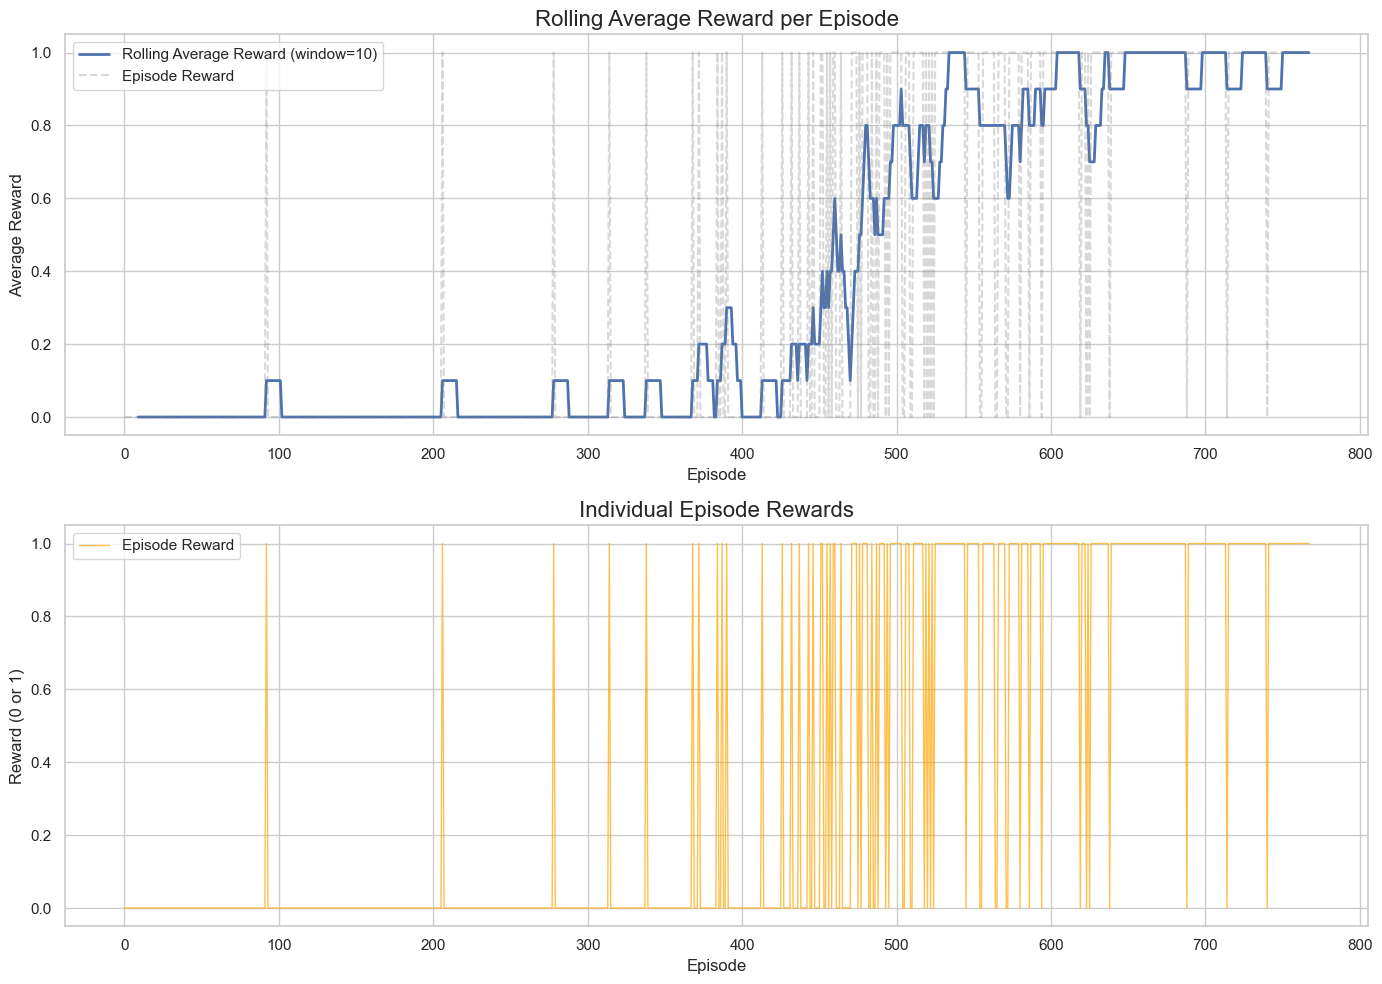

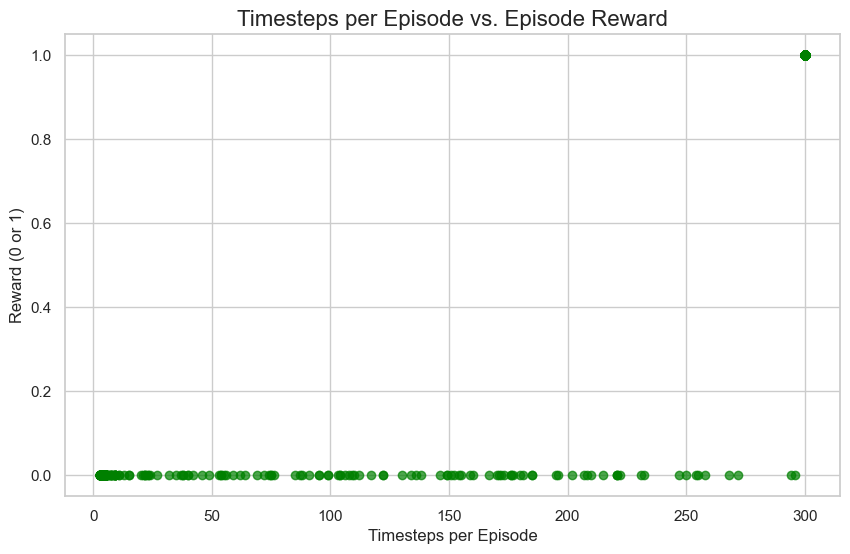

In [18]:
# Set style for seaborn
sns.set(style="whitegrid")

# Load the data from the monitor.csv file
file_path = './logs_with_rm/monitor.csv'
df = pd.read_csv(file_path, skiprows=1)

# Extract the necessary columns
episode_rewards = df['r']  # The rewards
episode_lengths = df['l']  # Episode lengths (timesteps per episode)
timesteps = df['t']        # Time elapsed for each episode 

# Parameters for rolling window
rolling_window_size = 10  # Adjust the window size for smoothing
rolling_rewards = episode_rewards.rolling(window=rolling_window_size).mean()

plt.figure(figsize=(14, 10))

# Plot 1: Rolling Average Reward per Episode
plt.subplot(2, 1, 1)
plt.plot(rolling_rewards, label=f'Rolling Average Reward (window={rolling_window_size})', color='b', linewidth=2)
plt.plot(episode_rewards, label='Episode Reward', alpha=0.3, linestyle='--', color='gray')
plt.title('Rolling Average Reward per Episode', fontsize=16)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Average Reward', fontsize=12)
plt.grid(True)
plt.legend(loc='upper left')

# Plot 2: Individual Episode Rewards (0 or 1)
plt.subplot(2, 1, 2)
plt.plot(episode_rewards, label='Episode Reward', alpha=0.7, color='orange', linewidth=1)
plt.title('Individual Episode Rewards', fontsize=16)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Reward (0 or 1)', fontsize=12)
plt.grid(True)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

'''
# Plot 3: Reward Distribution Histogram
plt.figure(figsize=(8, 5))
plt.hist(episode_rewards, bins=2, edgecolor='black', alpha=0.7, color='purple')
plt.title('Reward Distribution (0 vs 1)', fontsize=16)
plt.xlabel('Reward', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()
'''

# Plot 4: Timesteps per Episode vs. Episode Reward
plt.figure(figsize=(10, 6))
plt.scatter(episode_lengths, episode_rewards, alpha=0.7, color='green')
plt.title('Timesteps per Episode vs. Episode Reward', fontsize=16)
plt.xlabel('Timesteps per Episode', fontsize=12)
plt.ylabel('Reward (0 or 1)', fontsize=12)
plt.grid(True)
plt.show()

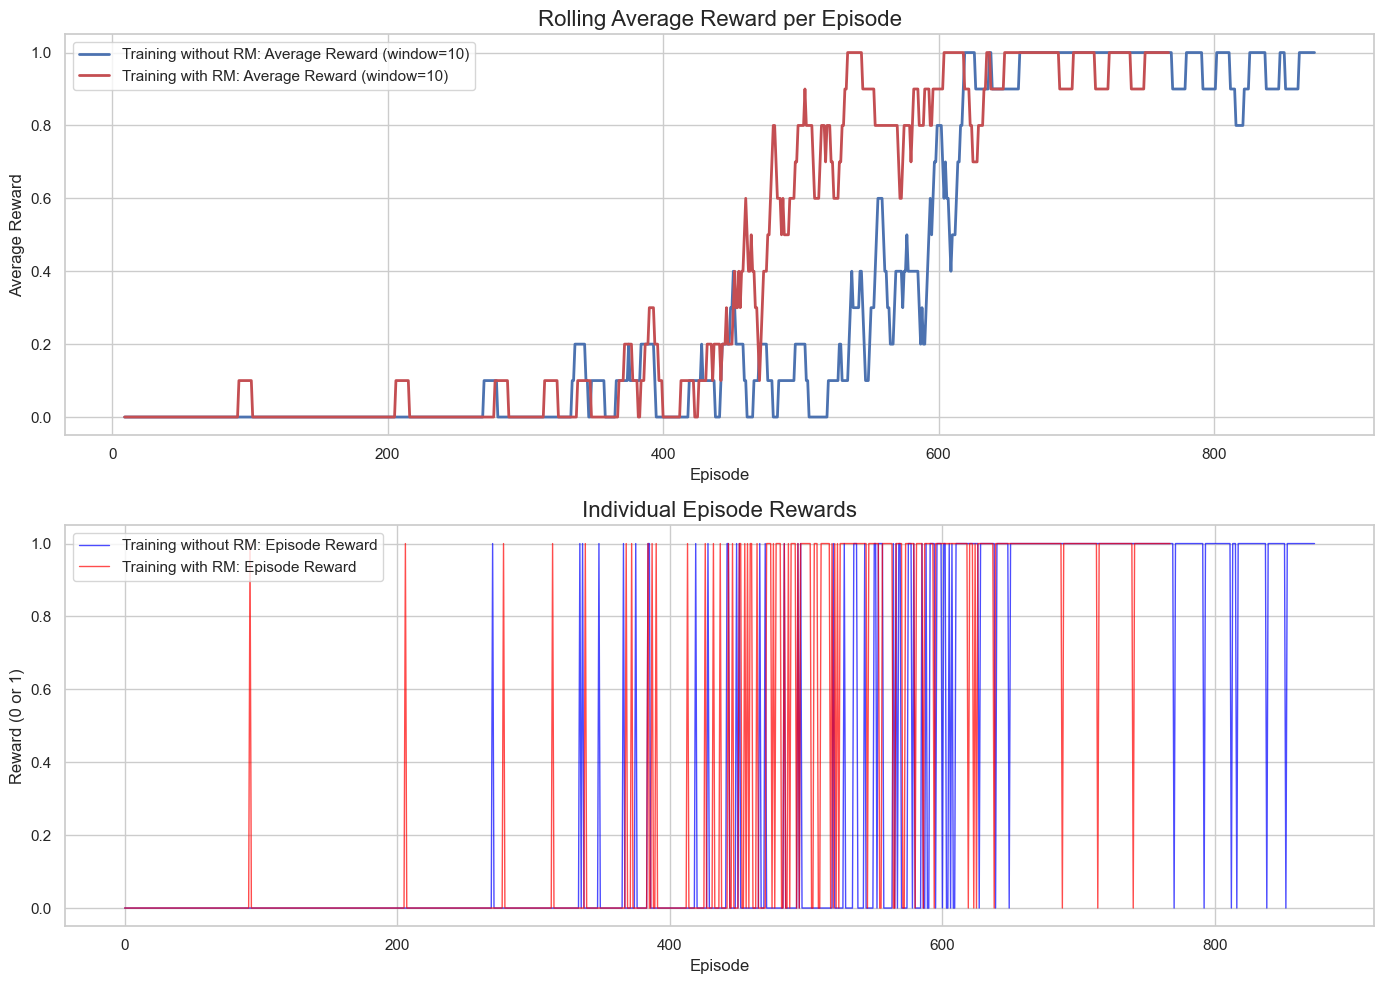

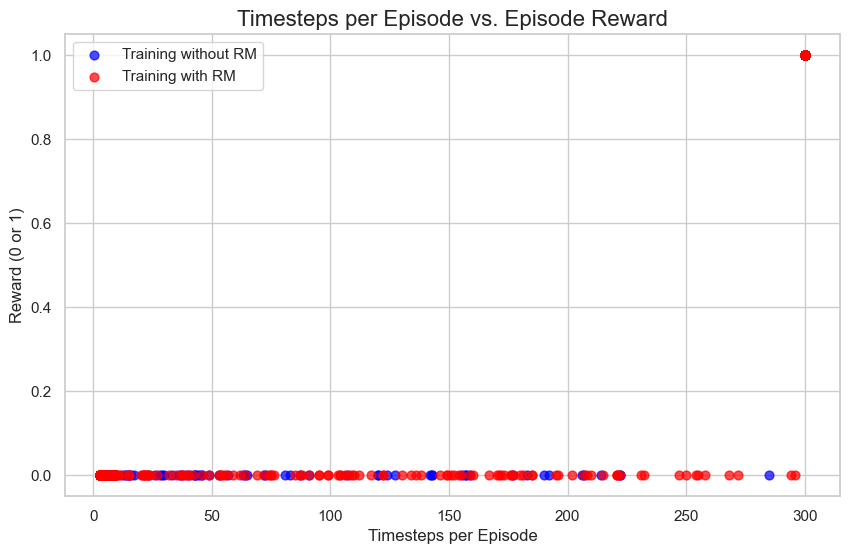

In [17]:
# Set style for seaborn
sns.set(style="whitegrid")

# Load the data from the two CSV files
file_path_1 = './logs_without_rm/monitor.csv'  # First training log
file_path_2 = './logs_with_rm/monitor.csv'  # Second training log

df1 = pd.read_csv(file_path_1, skiprows=1)
df2 = pd.read_csv(file_path_2, skiprows=1)

# Extract the necessary columns for both trainings
episode_rewards_1 = df1['r']  # Rewards for first training
episode_lengths_1 = df1['l']  # Episode lengths for first training
timesteps_1 = df1['t']        # Time elapsed for each episode 

episode_rewards_2 = df2['r']  # Rewards for second training
episode_lengths_2 = df2['l']  # Episode lengths for second training
timesteps_2 = df2['t']        # Time elapsed for each episode 

# Parameters for rolling window
rolling_window_size = 10  # Adjust the window size for smoothing
rolling_rewards_1 = episode_rewards_1.rolling(window=rolling_window_size).mean()
rolling_rewards_2 = episode_rewards_2.rolling(window=rolling_window_size).mean()

plt.figure(figsize=(14, 10))

# Plot 1: Rolling Average Reward per Episode for both trainings
plt.subplot(2, 1, 1)
plt.plot(rolling_rewards_1, label=f'Training without RM: Average Reward (window={rolling_window_size})', color='b', linewidth=2)
plt.plot(rolling_rewards_2, label=f'Training with RM: Average Reward (window={rolling_window_size})', color='r', linewidth=2)
plt.title('Rolling Average Reward per Episode', fontsize=16)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Average Reward', fontsize=12)
plt.grid(True)
plt.legend(loc='upper left')

# Plot 2: Individual Episode Rewards for both trainings
plt.subplot(2, 1, 2)
plt.plot(episode_rewards_1, label='Training without RM: Episode Reward', alpha=0.7, color='blue', linewidth=1)
plt.plot(episode_rewards_2, label='Training with RM: Episode Reward', alpha=0.7, color='red', linewidth=1)
plt.title('Individual Episode Rewards', fontsize=16)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Reward (0 or 1)', fontsize=12)
plt.grid(True)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Plot 3: Timesteps per Episode vs. Episode Reward (both trainings)
plt.figure(figsize=(10, 6))
plt.scatter(episode_lengths_1, episode_rewards_1, alpha=0.7, color='blue', label='Training without RM', s=40)
plt.scatter(episode_lengths_2, episode_rewards_2, alpha=0.7, color='red', label='Training with RM', s=40)
plt.title('Timesteps per Episode vs. Episode Reward', fontsize=16)
plt.xlabel('Timesteps per Episode', fontsize=12)
plt.ylabel('Reward (0 or 1)', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()


With RM Metrics:
Time Elapsed: [1.0, 4.0, 6.0, 8.0, 11.0, 13.0, 15.0, 17.0, 19.0, 21.0, 23.0, 25.0, 27.0, 30.0, 32.0, 34.0, 37.0, 39.0, 41.0, 43.0, 45.0, 47.0, 49.0, 51.0, 54.0, 56.0, 58.0, 60.0, 62.0, 64.0, 67.0, 72.0, 74.0, 76.0, 78.0, 80.0, 83.0, 85.0, 87.0, 89.0, 91.0, 93.0, 95.0, 98.0, 100.0, 102.0, 104.0, 106.0, 108.0]

Without RM Metrics:
Time Elapsed: [3.0, 6.0, 10.0, 13.0, 16.0, 20.0, 23.0, 26.0, 30.0, 33.0, 37.0, 40.0, 44.0, 47.0, 50.0, 54.0, 57.0, 60.0, 64.0, 67.0, 70.0, 74.0, 77.0, 81.0, 84.0, 87.0, 91.0, 94.0, 97.0, 101.0, 104.0, 107.0, 111.0, 114.0, 117.0, 121.0, 125.0, 128.0, 132.0, 136.0, 139.0, 143.0, 146.0, 149.0, 153.0, 157.0, 160.0, 164.0, 167.0]


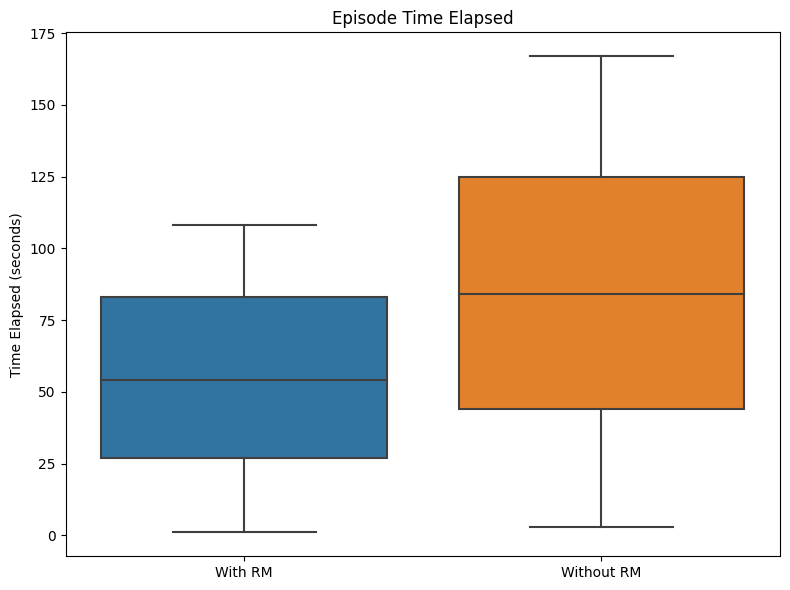

In [13]:
# Function to extract metrics from log file
def extract_metrics(filename):
    with open(filename, 'r') as file:
        content = file.read()

    # Extract Episode Length Mean (ep_len_mean)
    ep_len_mean = re.findall(r'ep_len_mean\s*\|\s*([\d.]+)', content)
    ep_len_mean = [float(x) for x in ep_len_mean]
    
    # Extract Episode Reward Mean (ep_rew_mean)
    ep_rew_mean = re.findall(r'ep_rew_mean\s*\|\s*([\d.]+)', content)
    ep_rew_mean = [float(x) for x in ep_rew_mean]
    
    # Extract Episode Time Elapsed (ep_time_elapsed)
    ep_time_elapsed = re.findall(r'time_elapsed\s*\|\s*([\d.]+)', content)
    ep_time_elapsed = [float(x) for x in ep_time_elapsed]
    

    return {
        'Time elapsed': ep_time_elapsed,
    }

# Print metrics collected from the log
def print_metrics(metrics):
    print("Time Elapsed:", metrics['Time elapsed'])
    
# Create boxplot for "Time Elapsed"
def create_time_boxplot(rm_metrics, no_rm_metrics):
    plt.figure(figsize=(8, 6))
    
    # Episode Time Elapsed Boxplot
    sns.boxplot(data=[rm_metrics['Time elapsed'], no_rm_metrics['Time elapsed']])
    plt.xticks([0, 1], ['With RM', 'Without RM'])
    plt.title('Episode Time Elapsed')
    plt.ylabel('Time Elapsed (seconds)')
    
    plt.tight_layout()
    plt.show()


rm_metrics = extract_metrics("./logs_with_rm/PPO_results_with_RM.txt")
no_rm_metrics = extract_metrics("./logs_without_rm/PPO_results_without_RM.txt")

# Print the metrics collected
print("With RM Metrics:")
print_metrics(rm_metrics)

print("\nWithout RM Metrics:")
print_metrics(no_rm_metrics)

create_time_boxplot(rm_metrics, no_rm_metrics)

In [15]:
import re

# Function to extract metrics from log file
def extract_metrics(filename):
    with open(filename, 'r') as file:
        content = file.read()

    # Use regex to capture action, avg times used
    pattern = r'(\w+)\s+(\d+)\s+(\d+\.\d+%)'
    matches = re.findall(pattern, content)

    # Initialize empty lists for each action
    metrics = {
        'connect': [],
        'restore_node': [],
        'isolate': [],
        'do_nothing': [],
        'scan':[]
    }

    # Fill the lists based on the matches
    for match in matches:
        action, avg_times, _ = match
        if action in metrics:
            metrics[action].append(float(avg_times))

    return metrics

# Print metrics collected from the log
def print_metrics(metrics):
    for action, times in metrics.items():
        print(f"{action.capitalize()} times: {times}")
        
def create_and_save_box_violin_plots(rm_metrics, no_rm_metrics, save_path='./'):
    actions = ['connect', 'restore_node', 'isolate', 'do_nothing', 'scan']
    
    for action in actions:
        plt.figure(figsize=(12, 6)) 
        
        # Create subplot: 1 row, 2 columns
        # boxplot
        plt.subplot(1, 2, 1)
        sns.boxplot(data=[rm_metrics[action], no_rm_metrics[action]])
        plt.xticks([0, 1], ['With RM', 'Without RM'])
        plt.title(f'{action.capitalize()} Boxplot')
        plt.ylabel('Avg time used')
        
        # Second subplot: violinplot
        plt.subplot(1, 2, 2)
        sns.violinplot(data=[rm_metrics[action], no_rm_metrics[action]], split=True)
        plt.xticks([0, 1], ['With RM', 'Without RM'])
        plt.title(f'{action.capitalize()} Violinplot')
        plt.ylabel('Avg time used')
        
        # Salve graphs as png
        plt.tight_layout()
        file_name = f"{save_path}{action}_box_violin_plot.png"
        plt.savefig(file_name)  
        plt.close() 

        print(f"Saved {action.capitalize()} plot as {file_name}")


# Collecting metrics
rm_metrics = extract_metrics("./logs_with_rm/PPO_results_with_RM.txt")
no_rm_metrics = extract_metrics("./logs_without_rm/PPO_results_without_RM.txt")

# Print the metrics collected
print("With RM Metrics:")
print_metrics(rm_metrics)

print("\nWithout RM Metrics:")
print_metrics(no_rm_metrics)

create_and_save_box_violin_plots(rm_metrics, no_rm_metrics)


With RM Metrics:
Connect times: [4.0, 1.0, 2.0, 5.0, 2.0, 2.0, 2.0, 1.0, 3.0, 11.0, 4.0, 6.0, 2.0, 3.0, 1.0, 1.0, 3.0, 1.0, 4.0, 2.0, 18.0, 9.0, 16.0, 6.0, 9.0, 2.0, 6.0, 24.0, 4.0, 21.0, 2.0, 29.0, 13.0, 19.0, 16.0, 19.0, 25.0, 21.0, 30.0, 23.0, 14.0, 20.0, 40.0, 55.0, 24.0, 53.0, 47.0, 66.0, 50.0, 70.0, 57.0, 65.0, 65.0, 80.0, 69.0, 72.0, 67.0, 66.0, 64.0, 64.0, 76.0, 64.0, 65.0, 70.0, 63.0, 65.0, 66.0, 59.0, 51.0, 52.0, 55.0, 47.0, 55.0, 60.0, 61.0, 55.0]
Restore_node times: [3.0, 2.0, 2.0, 5.0, 1.0, 2.0, 1.0, 2.0, 1.0, 11.0, 5.0, 4.0, 2.0, 3.0, 2.0, 2.0, 4.0, 2.0, 4.0, 1.0, 16.0, 10.0, 13.0, 4.0, 13.0, 2.0, 5.0, 20.0, 2.0, 22.0, 1.0, 26.0, 8.0, 18.0, 14.0, 17.0, 22.0, 23.0, 29.0, 17.0, 10.0, 17.0, 30.0, 47.0, 18.0, 45.0, 38.0, 59.0, 46.0, 68.0, 57.0, 61.0, 60.0, 78.0, 67.0, 65.0, 56.0, 64.0, 60.0, 66.0, 66.0, 65.0, 69.0, 69.0, 75.0, 76.0, 78.0, 81.0, 72.0, 79.0, 75.0, 78.0, 74.0, 75.0, 66.0, 67.0]
Isolate times: [3.0, 2.0, 1.0, 4.0, 2.0, 1.0, 2.0, 2.0, 1.0, 11.0, 3.0, 4.0, 1.0, 2.0